<a href="https://colab.research.google.com/github/davifcs/ia006/blob/master/Lista3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Bibliotecas 
O desenvolvimento do exerciício se deu na linguagem de programção Python e as bibliotecas utilizadas são as que seguem abaixo.

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
from scipy.io import loadmat
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
import seaborn as sbn
from mlxtend.plotting import plot_decision_regions

---


###Natureza dos dados
Os dados disponiveis na página do curso http://www.dca.fee.unicamp.br/~lboccato/ia006_2s2019.html foram carregados. Os conjuntos de dados de treino e validação foram concatenados em um só, já que os pacotes de treinamento utilizados para o desensolvimento do exerício são capazes de atribuir dados ao conjunto de validação automaticamente.

Além disso, a classe C- foi moditificada para apresentar os valores de classificação como 0 sendo a C+ como 1.


In [0]:
train = loadmat('dados_treinamento.mat')
val = loadmat('dados_val.mat')
test = loadmat('dados_teste.mat')

train_X = np.asarray(train['X'])
train_y = np.asarray(train['y'])
train_X = train_X
train_y = train_y.T[0] 
train_y[train_y == -1] = 0

val_X = np.asarray(val['Xval'])
val_y = np.asarray(val['yval'])
val_X = val_X
val_y = val_y.T[0]
val_y[val_y == -1] = 0

train_val_X = np.concatenate((train_X, val_X), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)

test_X = np.asarray(test['Xt'])
test_y = np.asarray(test['yt'])
test_X = test_X
test_y = test_y.T[0]
test_y[test_y == -1] = 0


---


##Classificação binária - MLP

* Uma única camada intermediária foi utilizada
* Foram testadas quatro tipos de configurações diferentes para a camada intermediária, sendo essas: 2, 4, 8 e 16 neurônios.
  * Os neurônios na camada intermedária atuam como detectores de características. Tais neurônios são capazes de tal tarefa executando uma transformação não linear nos dados de entrada em um novo espaço chamado *feature space*. Pela figura apresentada como regiões de decisão correspondentes ao classificador ótimo (MAP), percebe-se que não é possível separar o conjunto de dados de maneira linear, ou seja, mais de um neurônio na camada intermediária será necessário.
* A função de ativação escolhida para a camada intermediária foi a designada como ReLu.
* Uma vez que o problema é do tipo classificação binária, a função de ativação escolhida para a camada de saída foi a Sigmoid.
* O otimizador utilizado o Adam (Adam: A Method for Stochastic Optimization, Diederik P. Kingma & Jimmy Ba, 2014). 
  * A parametrização do otimizador é igual à apresentada no artigo original com exceção da taxa de aprendizado: $\alpha$ = 0,0001; $\beta_1$ = 0,9; e $\beta_2$ = 0,999.
* O conjunto de validação apresentado na seção Natureza dos Dados contempla 50% do conjunto total de treino, sendo assim, foi definido como conjunto de validação 50% dos dados de treino.
* Um total de 10000 épocas foi estabelecido
* Estratégias de *early-stopping* com paciência em 2000 épocas, bem como um *checkpoint* do modelo de melhor desempenho no conjunto de validação foram utilizadas.

#### 2 neurônios

A curva de entropia cruzada para o conjunto de treino e validação, pode ser conferida a seguir. A estratégia de *early-stopping* interrompeu o treinamento perto de 2500 épocas.

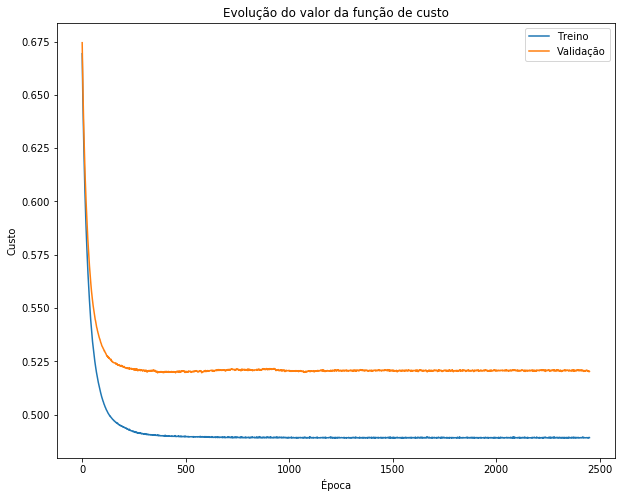

In [0]:
model = Sequential()
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=2000, 
                                        verbose=False, mode='min')

model_checkpoint = callbacks.ModelCheckpoint('/content/model.h5', 
                                             save_best_only=False, 
                                             save_weights_only=False, 
                                             monitor='val_loss',
                                             mode='min')

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(train_val_X, train_val_y, validation_split=0.5, 
                    epochs=10000, verbose=False, 
                    callbacks= [earlyStopping,model_checkpoint])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Evolução do valor da função de custo')
plt.ylabel('Custo')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()


As regiões de decisão podem ser conferidas a seguir, é possível perceber que dois neurônios na camada intermediária apresentaram regiões de decisão muito diferentes daquelas esperadas pelo classificador ótimo (MAP), efeito disso, é uma acurácia de 73% frente ao conjunto de teste.

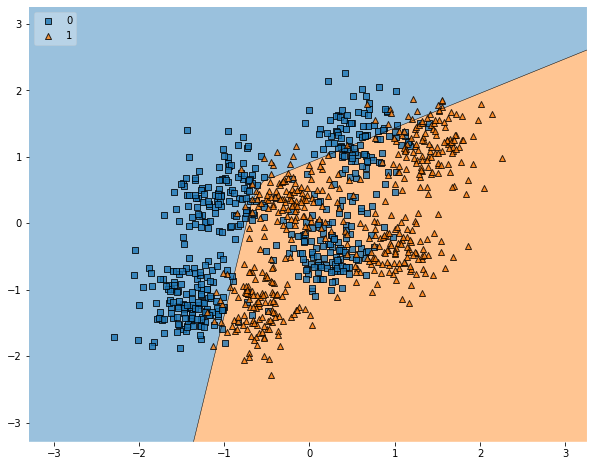

              precision    recall  f1-score   support

           0       0.85      0.57      0.68       499
           1       0.68      0.90      0.77       501

    accuracy                           0.73      1000
   macro avg       0.76      0.73      0.73      1000
weighted avg       0.76      0.73      0.73      1000



In [0]:
mlp = load_model("/content/model.h5")
decision_regions = plot_decision_regions(train_X, train_y, clf=mlp, legend=2)
plt.show(decision_regions)

test_p = mlp.predict_classes(test_X)
report = classification_report(test_y, test_p)  
print(report)

#### 4 neurônios

Uma MLP foi testada, dessa vez com quatro neurônios na camada intermediária. A curva de entropia cruzada para o conjunto de treino e validação, pode ser conferida a seguir. A estratégia de *early-stopping* interrompeu o treinamento com mais de 6000 épocas.



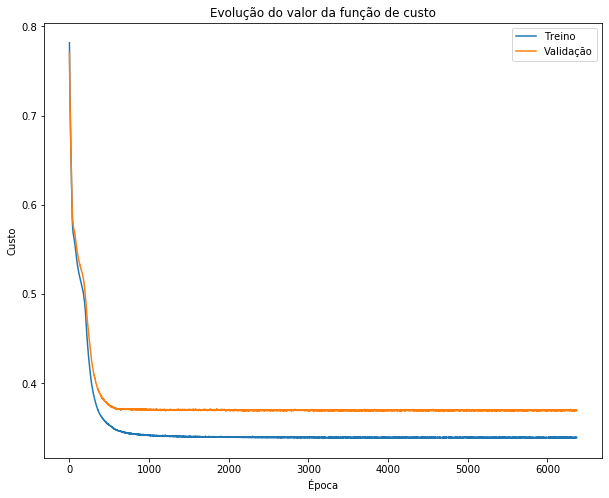

In [0]:
model = Sequential()
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=2000, 
                                        verbose=False, mode='min')

model_checkpoint = callbacks.ModelCheckpoint('/content/model.h5', 
                                             save_best_only=False, 
                                             save_weights_only=False, 
                                             monitor='val_loss',
                                             mode='min')

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(train_val_X, train_val_y, validation_split=0.5, 
                    epochs=10000, verbose=False, 
                    callbacks= [earlyStopping,model_checkpoint])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Evolução do valor da função de custo')
plt.ylabel('Custo')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()

Dessa vez as regiões de decisão, com quatro neurônios na camada intermediária, se assemelham muito mais com às apresentadas pelo classificador ótimo (MAP), agora a rede frente ao conjunto de teste alcançou 89% de acurácia.  

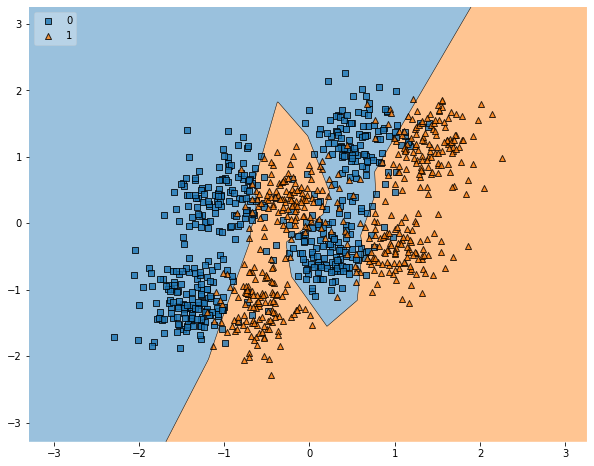

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       499
           1       0.89      0.88      0.89       501

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [0]:
mlp = load_model("/content/model.h5")
decision_regions = plot_decision_regions(train_X, train_y, clf=mlp, legend=2)
plt.show(decision_regions)

test_p = mlp.predict_classes(test_X)
report = classification_report(test_y, test_p)  
print(report)

#### 8 neurônios

Agora com oito neurônios na camada intermediária a rede foi treinada. A curva de entropia cruzada para o conjunto de treino e validação, pode ser conferida a seguir. A estratégia de *early-stopping* interrompeu o treinamento com quase 6000 épocas, além disso, é possível perceber que com aproximadamente 4000 épocas o erro de validação começou a aumentar.


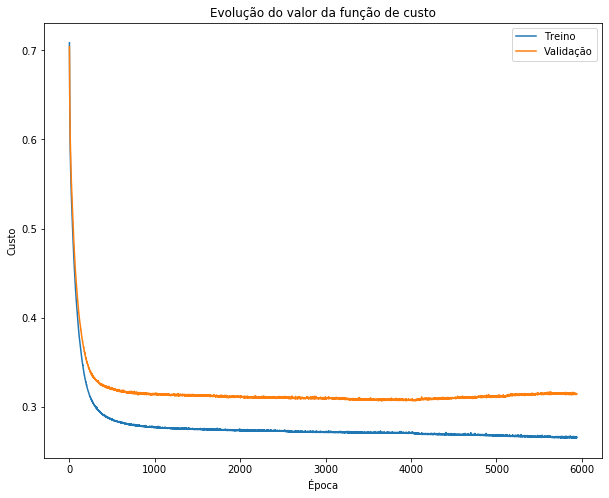

In [0]:
model = Sequential()
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=2000, 
                                        verbose=False, mode='min')

model_checkpoint = callbacks.ModelCheckpoint('/content/model.h5', 
                                             save_best_only=False, 
                                             save_weights_only=False, 
                                             monitor='val_loss',
                                             mode='min')

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(train_val_X, train_val_y, validation_split=0.5, 
                    epochs=10000, verbose=False, 
                    callbacks= [earlyStopping,model_checkpoint])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Evolução do valor da função de custo')
plt.ylabel('Custo')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()

As regiões de decisão apresentão um maior número de arestas quando comparadas às regiões de decisão para o caso de quatro neurônios. Entretanto isso não significou um melhor desempenho frente ao conjunto de teste, no caso, a acurácia reduziu 1%, ficando então em 88%.

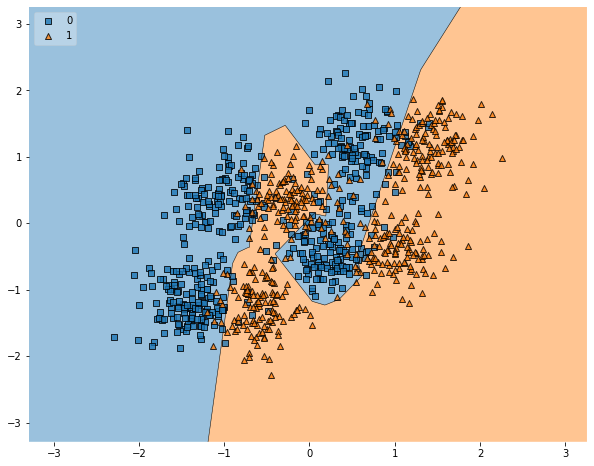

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       499
           1       0.89      0.88      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [0]:
mlp = load_model("/content/model.h5")
decision_regions = plot_decision_regions(train_X, train_y, clf=mlp, legend=2)
plt.show(decision_regions)

test_p = mlp.predict_classes(test_X)
report = classification_report(test_y, test_p)  
print(report)

#### 16 neurônios

Com o intuito de experimentação o número de neurônios na camada intermediária foi elevado para dezesseis. A estratágia de *early-stopping* interrompeu o treinamento perto de 4000 épocas. 

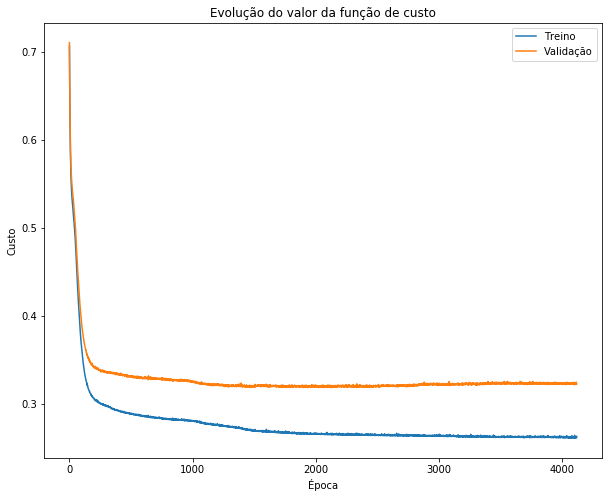

In [0]:
model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=2000, 
                                        verbose=False, mode='min')

model_checkpoint = callbacks.ModelCheckpoint('/content/model.h5', 
                                             save_best_only=False, 
                                             save_weights_only=False, 
                                             monitor='val_loss',
                                             mode='min')

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(train_val_X, train_val_y, validation_split=0.5, 
                    epochs=10000, verbose=False, 
                    callbacks= [earlyStopping,model_checkpoint])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Evolução do valor da função de custo')
plt.ylabel('Custo')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()

A região de decisão para esse caso apresentou uma "flexibilidade" maior ainda quando comparada aos casos anteriores. Novamente, isso não representou um melhor desempenho da rede frente ao conjunto de teste, no caso a acurácia ficou em 88%. 

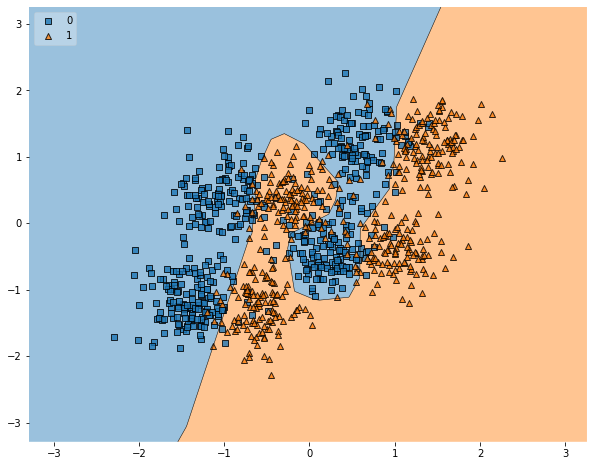

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       499
           1       0.88      0.88      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [0]:
mlp = load_model("/content/model.h5")
decision_regions = plot_decision_regions(train_X, train_y, clf=mlp, legend=2)
plt.show(decision_regions)

test_p = mlp.predict_classes(test_X)
report = classification_report(test_y, test_p)  
print(report)

É provável que se um novo modelo fosse treinado com um número ainda maior de neurônios na camada intermediária, o modelo começaria a apresentar característiacs de *overfitting*, onde a rede perde poder de generalização ao aprender características específicas do conjunto de treinamento. Sendo assim, o melhor modelo estudado é aquele que usa quatro neurônios na camada intermediária.

---


##Classificação binária - SVM

* O *Kernel* utilizado é do tipo RBF (*Radian Basis Funcion*) que é do tipo Gausiano.
  * Pela figura apresentada como regiões de decisão correspondentes ao classificador ótimo (MAP), percebe-se que o modelo é claramente não separável linearmente, sendo assim um *Kernel* do tipo linear foi descartado. Tal região até mesmo para um *Kernel* do tipo polinomial poderia ser problemática, portanto, o *Kernel* do tipo RBF que é capaz de resolver problemas do tipo XOR foi escolhido.
* O parâmetro de regularização C a princípio foi definido como unitário. Esse informa o quão aceitaveis são classificações incorretas. Quanto maior o valor de C menor a margem e vice-versa. 

* O parâmetro $\gamma$ que de certa maneira é o inverso do raio de influência das amostras selecionadas como vetores suporte, foi definido como o inverso da dimensão dos vetores x, ou seja, $\gamma$ = 1/2. 

In [0]:
svc = svm.SVC(kernel='rbf', C=1, gamma=1/len(train_val_X[0]))
svc.fit(train_val_X, train_val_y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

A seguir é possível identificar as regiões de decisão estabelecidas pelo método SVM, bem como as amostras utilizadas para seu treinamento.

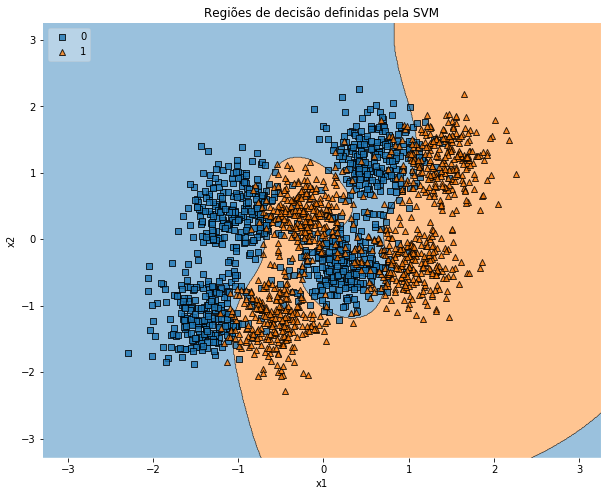

In [0]:
dr = plot_decision_regions(train_val_X, train_val_y, clf=svc, legend=2)
plt.title('Regiões de decisão definidas pela SVM')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

No total foram identificados 951 vetores suporte e a distribuição destes no espaço original dos dados pode ser verificada a seguir.

C- 475
C+ 476


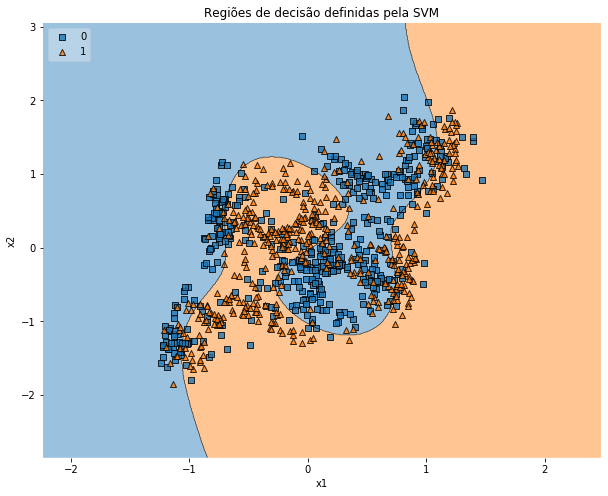

In [0]:
print("C-", svc.n_support_[0])
print("C+", svc.n_support_[1])

support_vector_X = train_val_X[svc.support_]
support_vector_y = train_val_y[svc.support_]

dr = plot_decision_regions(support_vector_X, support_vector_y, clf=svc, legend=2)
plt.title('Regiões de decisão definidas pela SVM')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

Aplicando a SVM treinada aos dados de teste temos que a acurácia é 88%, o que é bem similar ao desempenho apresentado no caso MLP.

In [0]:
test_p = svc.predict(test_X)
report = classification_report(test_y, test_p)  
print(report)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       499
           1       0.88      0.87      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



Mantendo o fator de regularização C = 1 e fazendo a modificação $\gamma$ = 5 o que equivale à regiões de decisão mais flexíveis, temos o resultado que apresenta um melhor *Recall* para a classe C+ e precisão para a classe C-, mas sem diferença na acurácia.

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       499
           1       0.88      0.89      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



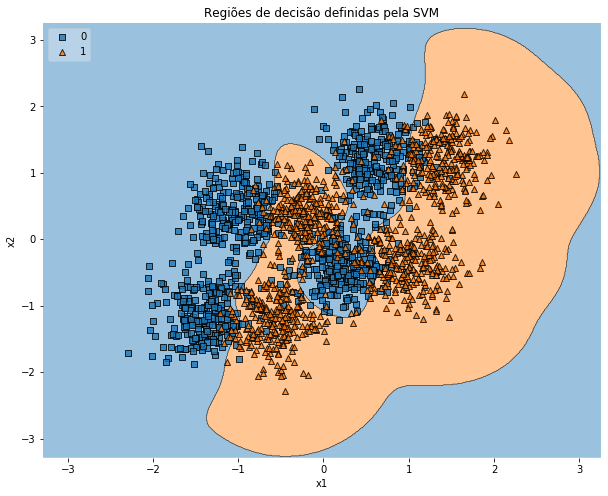

In [0]:
svc = svm.SVC(kernel='rbf', C=1, gamma=5)
svc.fit(train_val_X, train_val_y)
test_p = svc.predict(test_X)
report = classification_report(test_y, test_p)  
print(report)

dr = plot_decision_regions(train_val_X, train_val_y, clf=svc, legend=2)
plt.title('Regiões de decisão definidas pela SVM')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

Agora mantendo $\gamma$ = 1/2, mas fazendo C = 0.01, o que equivale a uma maior margem, temos uma significativa piora na acurácia agora essa sendo de 66%. Também, é possível notar que as regiões de decisão estão muito mais rígidas. 

              precision    recall  f1-score   support

           0       0.67      0.63      0.65       499
           1       0.65      0.69      0.67       501

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



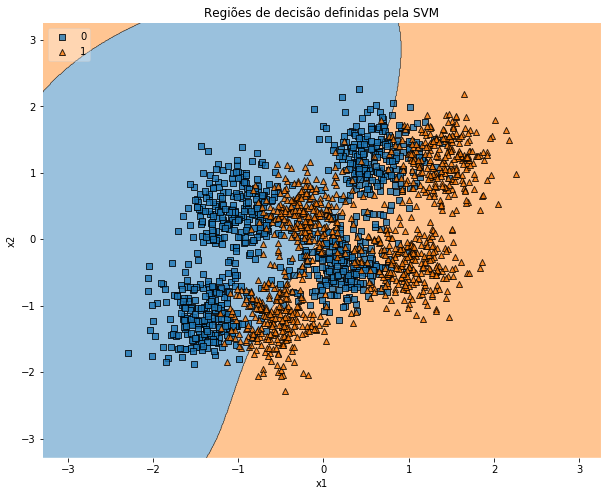

In [0]:
svc = svm.SVC(kernel='rbf', C=0.01, gamma=1/len(train_val_X[0]))
svc.fit(train_val_X, train_val_y)
test_p = svc.predict(test_X)
report = classification_report(test_y, test_p)  
print(report)

dr = plot_decision_regions(train_val_X, train_val_y, clf=svc, legend=2)
plt.title('Regiões de decisão definidas pela SVM')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

Finalmente, fazendo $\gamma$ = 1/2 e C = 0.01, foi obtida uma pequena melhora na acurácia, que agora é de 89%. No entanto, é muito provável que o modelo esteja apresentando certo *overfitting*, mesmo sendo avaliado junto ao conjunto de teste, pois as regiões de decisão estão muito longe das apresentadas pelo classificador ótimo (MAP).

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       499
           1       0.88      0.91      0.90       501

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



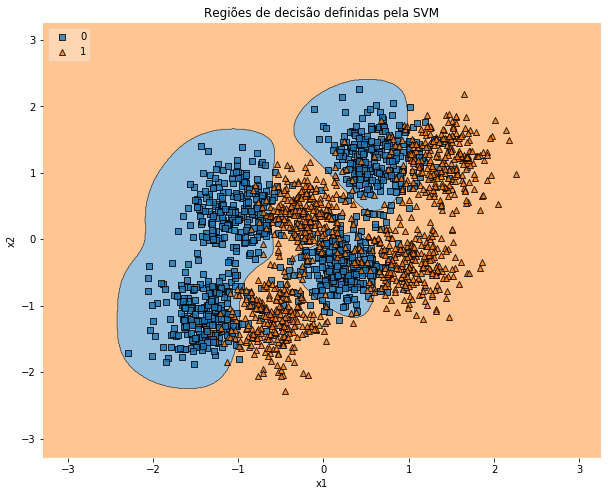

In [0]:
svc = svm.SVC(kernel='rbf', C=0.01, gamma=5)
svc.fit(train_val_X, train_val_y)
test_p = svc.predict(test_X)
report = classification_report(test_y, test_p)  
print(report)

dr = plot_decision_regions(train_val_X, train_val_y, clf=svc, legend=2)
plt.title('Regiões de decisão definidas pela SVM')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

Como conclusão a melhor configuração para a SVM foi decidida por ser aquela com C = 1 e $\gamma$ = 1/2, pois embora outra configuração possa até apresentar uma melhor acurácia, é possível perceber pelas regiões de decisão que uma situação de *overfitting* pode ser o caso.